In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn

In [2]:
Nx= 200
#cfl= 0.2
tmax = 1 # time 0 ~ 1
viscosity_coeff = (0.01/math.pi)

x = np.linspace(-1,1, 200)

#t = 0  , I.C
u = -1*np.sin(math.pi * x)
dx = abs(x[1]-x[0])

dt = 0.002# cfl * dx / np.max(np.abs(u))

nt = int(tmax/ dt) #+ 1

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(nt)
print(dt)
print(nt * dt, tmax )

500
0.002
1.0 1


In [3]:
#u

In [4]:
#np.roll(u,-1)

In [5]:
def f(u):
    y = 0.5 * u**2
    yp = u
    return y, yp

In [6]:
def minmod(a,b):
    return 0.5 * (np.sign(a)+ np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [7]:
def RHS(u, dx, viscosity_coeff):
    #diffusion term
    diffusion_term = viscosity_coeff * (np.roll(u,1)- 2*u + np.roll(u,-1))/ dx**2
    
    ux = minmod((u - np.roll(u,1))/dx ,  (np.roll(u,-1) - u)/dx)
    
    uL = np.roll(u -0.5 * dx*ux,1)
    uR = u -0.5 * dx*ux
    fL,fpL = f(uL)
    fR,fpR = f(uR)
    a = np.maximum(np.abs(fpL), np.abs(fpR))
    
    H =0.5 * (fL + fR - a * (uR - uL))
    
    conv_term  = -(np.roll(H,-1)-H)/dx
    
    y = conv_term + diffusion_term
    return y

In [8]:
for i in range(1, nt):
    u1 = u + dt * RHS(u,dx,viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx,viscosity_coeff))
    uf[i, :] = u

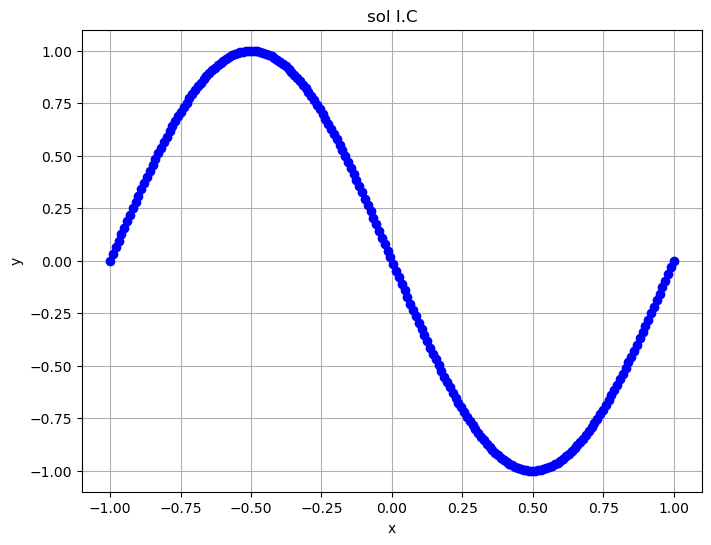

In [9]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.title("sol I.C")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

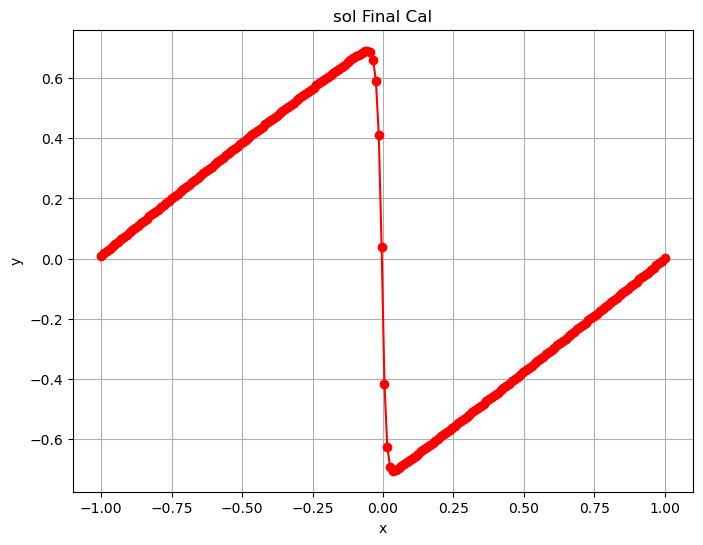

In [10]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol Final Cal")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

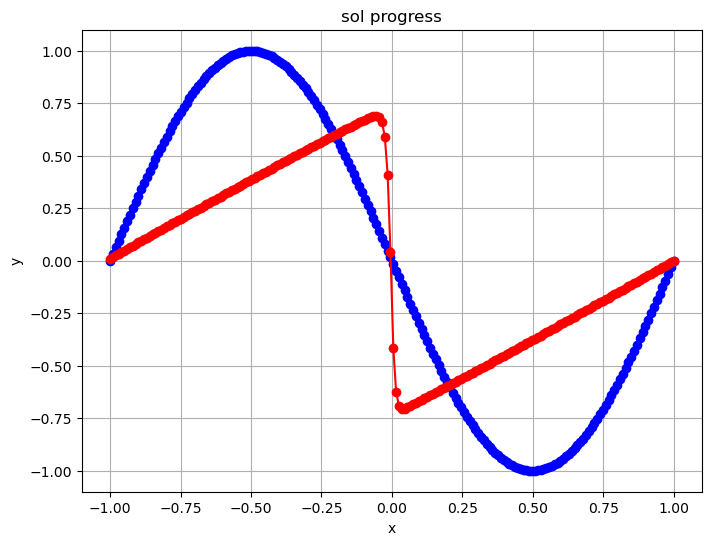

In [11]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol progress")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [12]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi = 3000)
sns.heatmap(uf.T, cmap = 'jet')

<Axes: >

In [13]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

In [14]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # comp. domain 
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        print(y_ic)
        
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
    
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        loss_pde = self.criterion(du_dt + 1*u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [15]:
# training
net = Net()
net.train()
net.model.eval()

C:\Users\mecha\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([-8.7423e-08,  3.0902e-01,  5.8779e-01,  8.0902e-01,  9.5106e-01,
         1.0000e+00,  9.5106e-01,  8.0902e-01,  5.8779e-01,  3.0902e-01,
         9.3627e-09, -3.0902e-01, -5.8779e-01, -8.0902e-01, -9.5106e-01,
        -1.0000e+00, -9.5106e-01, -8.0902e-01, -5.8779e-01, -3.0902e-01,
         8.7423e-08])
100 0.13999363780021667
200 0.08192041516304016
300 0.06488537788391113
400 0.03828835487365723
500 0.02220122702419758
600 0.014629043638706207
700 0.011939105577766895
800 0.015303807333111763
900 0.009083705022931099
1000 0.008189872838556767
1100 0.003685537725687027
1200 0.0016838290030136704
1300 0.0009300285018980503
1400 0.0006406817701645195
1500 0.00045785808470100164
1600 0.0003843763843178749
1700 0.000308862014207989
1800 0.00025880965404212475
1900 0.00021467218175530434
2000 0.00017154813394881785
2100 0.00014291208935901523
2200 0.00012035017425660044
2300 0.00010906258103204891
2400 9.497749852016568e-05
2500 8.662354230182245e-05
2600 7.573234324809164e-05
270

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [16]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

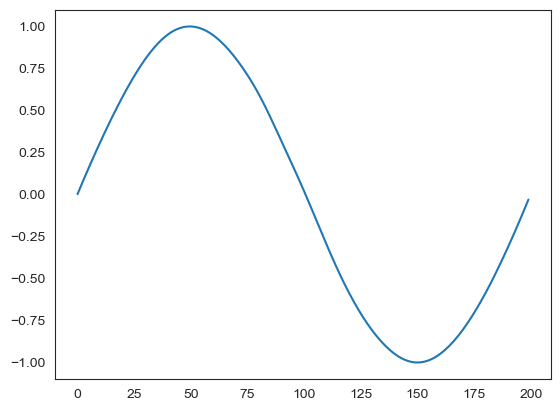

In [17]:
#I.C
plt.plot(y_pred[:,0])

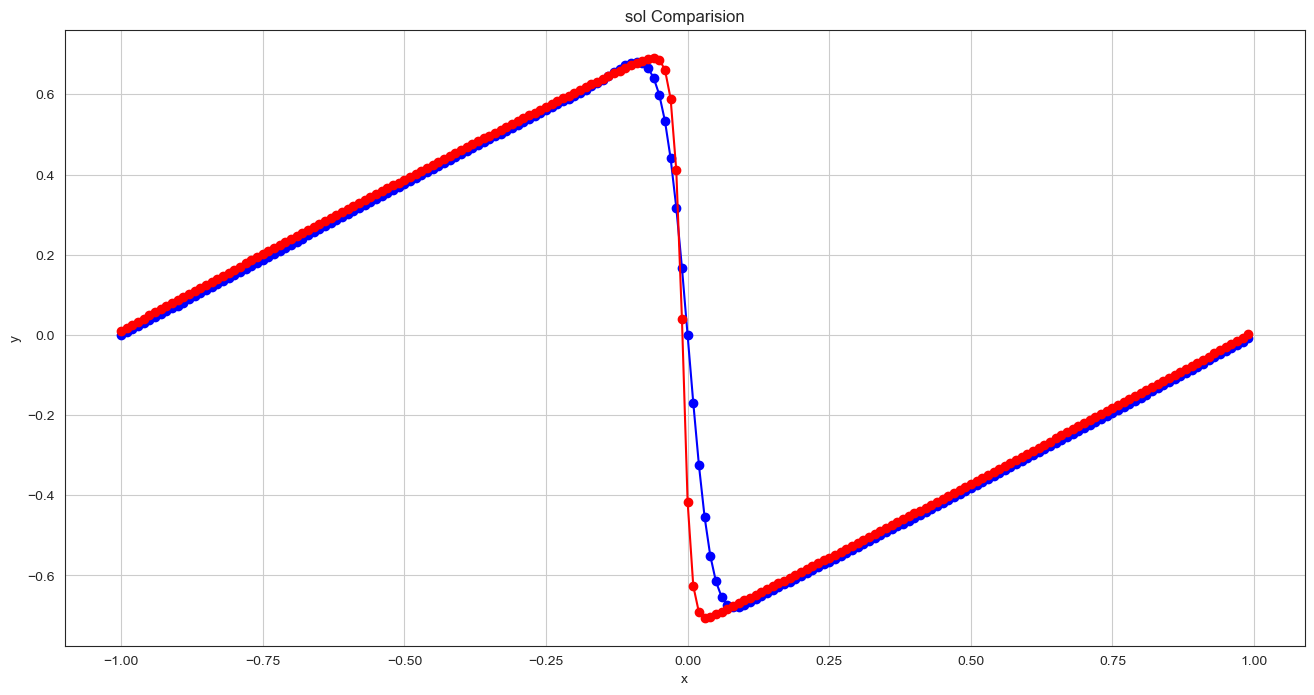

In [19]:
plt.figure(figsize=(16,8))
plt.plot(x, y_pred[:,-1], '-o', color = 'b') #PINNs
plt.plot(x, uf[-1], '-o', color = 'r') #TVD
plt.title("sol Comparision")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()